## LOADING THE DATASET

In [1]:
from keras.datasets import mnist
import numpy as np

(trainImages, _), (testImages, _) = mnist.load_data()

trainImages, testImages = trainImages / 255.0, testImages / 255.0

#print("Training dimensions:", trainImages.shape)
#print("Test dimensions:", testImages.shape)

flattenedTrainImages = trainImages.reshape((trainImages.shape[0], -1))
flattenedTestImages = testImages.reshape((testImages.shape[0], -1))

print("Flattened training dimensions:", flattenedTrainImages.shape)
print("Flattened test dimensions:", flattenedTestImages.shape)

np.random.seed(42)      #To ensure that same images are used across pca and ppca. Change seed value for different images
selectedImages = np.random.choice(len(testImages), size = 5, replace=False)

Flattened training dimensions: (60000, 784)
Flattened test dimensions: (10000, 784)


## PCA IMPLEMENTATION

MSE for latent dimension 2 is: 0.05566949193442309


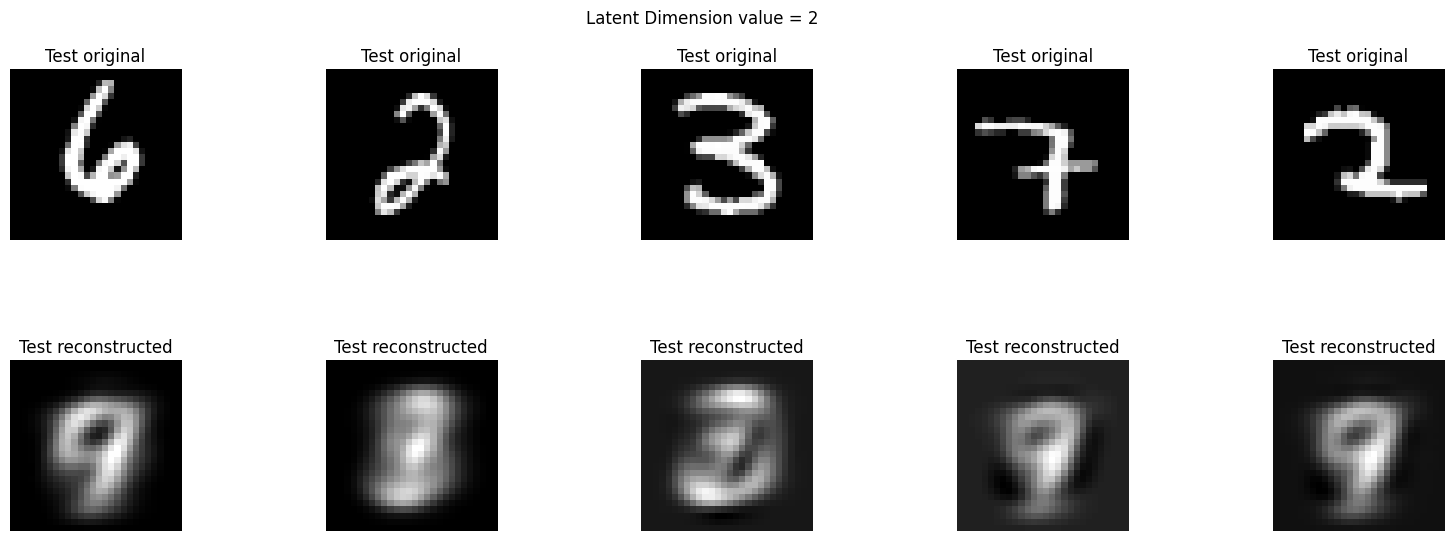

MSE for latent dimension 4 is: 0.04790346506558457


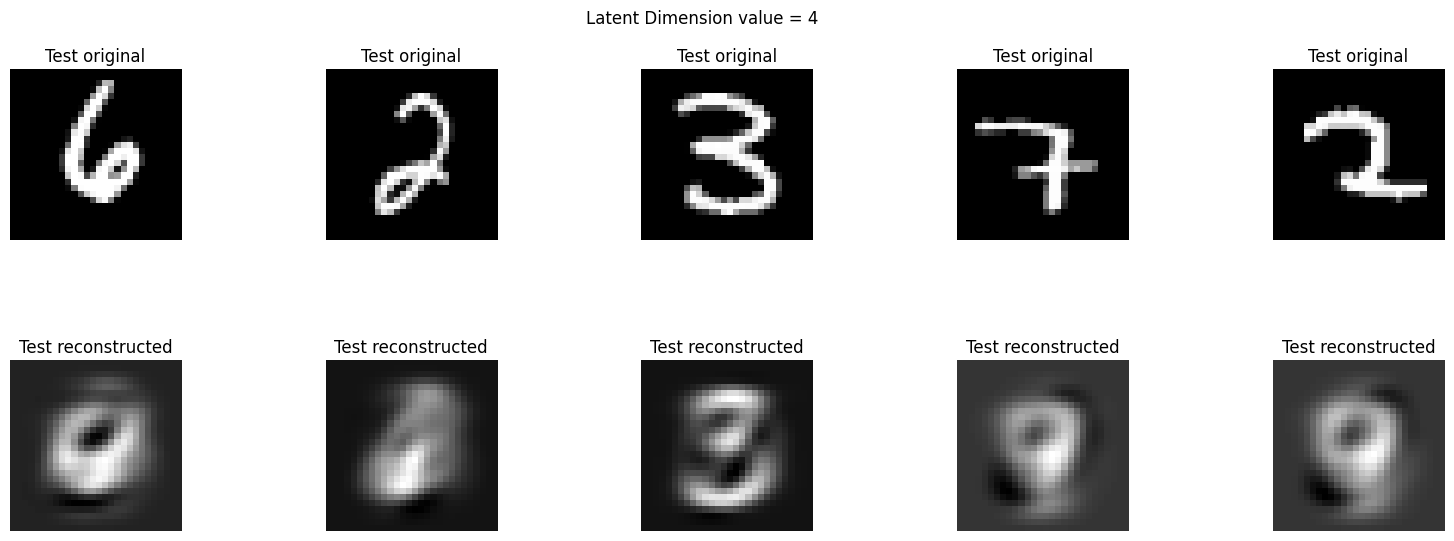

MSE for latent dimension 8 is: 0.037440933919030965


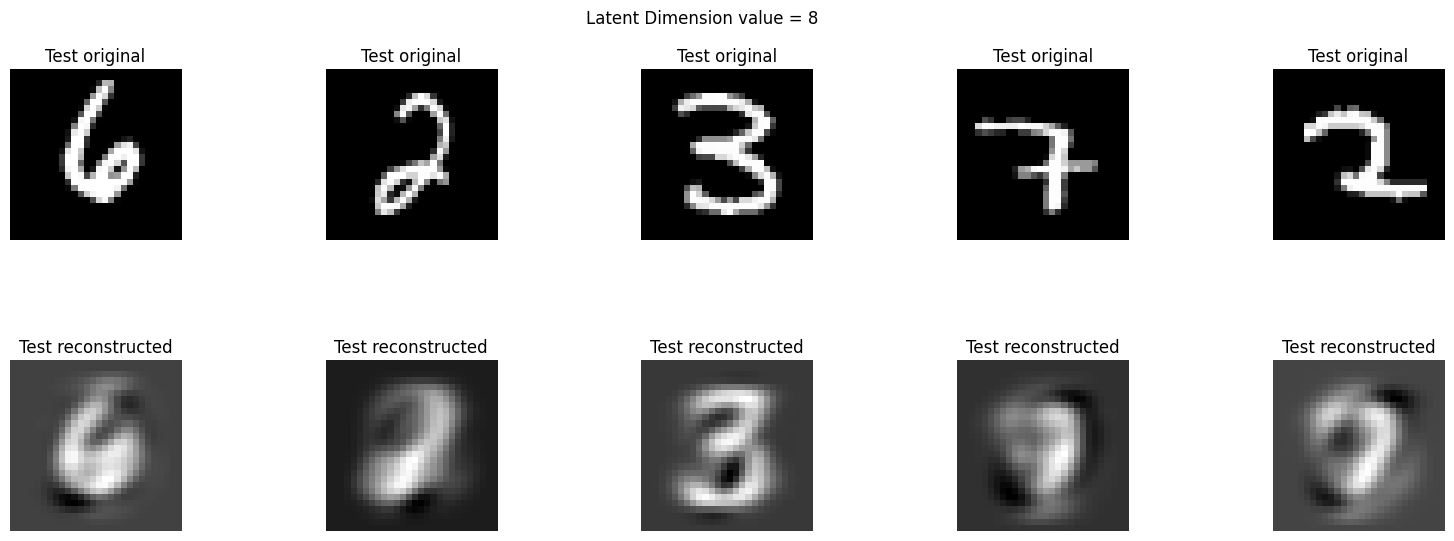

MSE for latent dimension 16 is: 0.02686019078827122


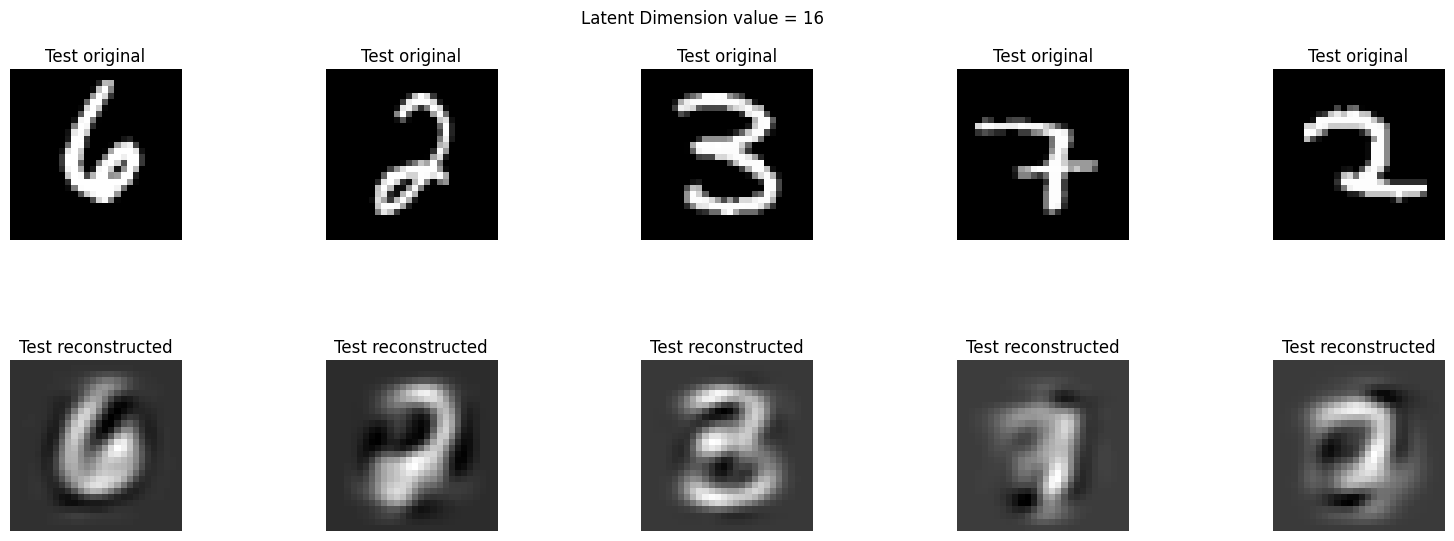

MSE for latent dimension 32 is: 0.016829987691859553


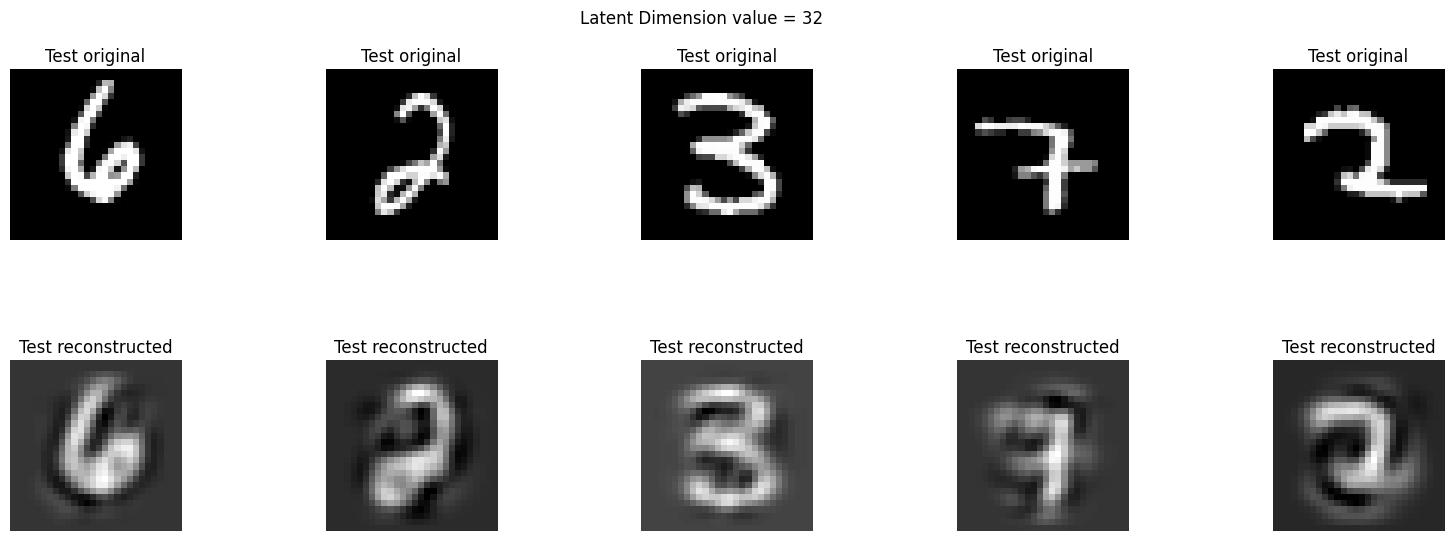

MSE for latent dimension 64 is: 0.009047770446754689


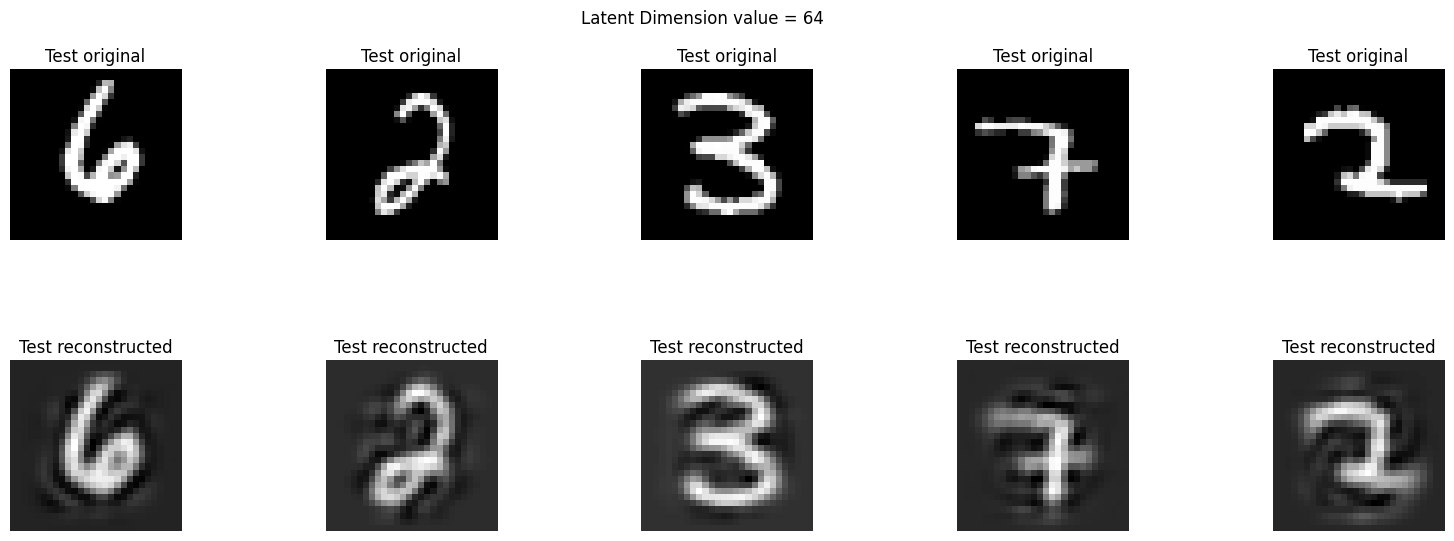

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64] 

def pcaFn(latentDimensionValue, flattenedTestImages):
    pca = PCA(n_components=latentDimensionValue)
    pca.fit(flattenedTrainImages)

    transformedImages = pca.inverse_transform(pca.transform(flattenedTestImages))
    transformedImages = transformedImages.reshape((-1, 28 * 28))    #Converting into 2d array

    return transformedImages

def pcaMSE(originalImages, reconstructedImages):
    return np.mean((originalImages - reconstructedImages)**2)

for latentDimensionValue in latentDimensions:

    reconstructedImages = pcaFn(latentDimensionValue, flattenedTestImages)
    mseVal = pcaMSE(flattenedTestImages,reconstructedImages)

    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent Dimension value = {latentDimensionValue}")

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()



## PROBABILISTIC PCA IMPLEMENTATION

MSE val for latent dimension 2 is 0.06742457947489407


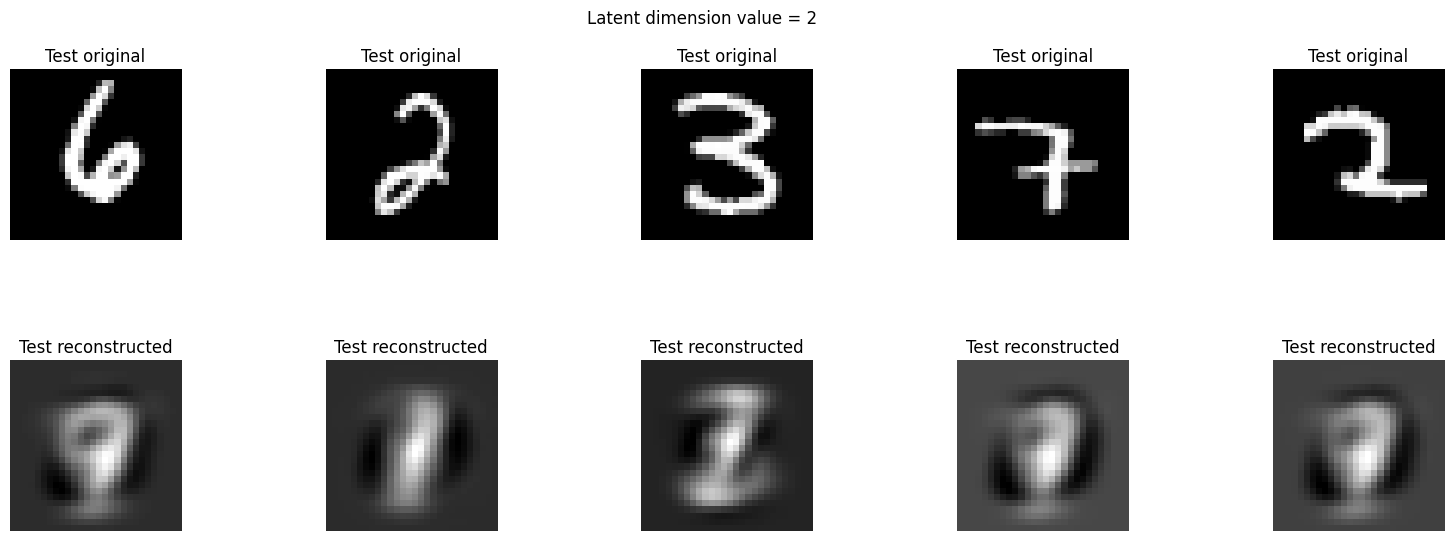

MSE val for latent dimension 4 is 0.06468975344922344


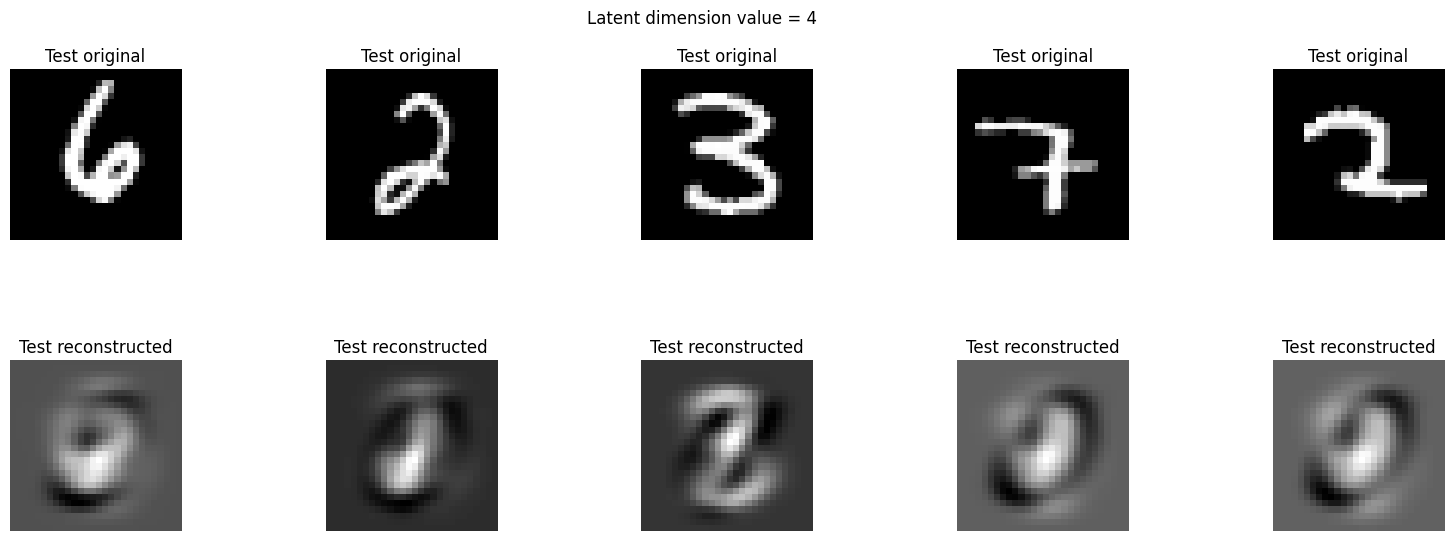

MSE val for latent dimension 8 is 0.07750603873773998


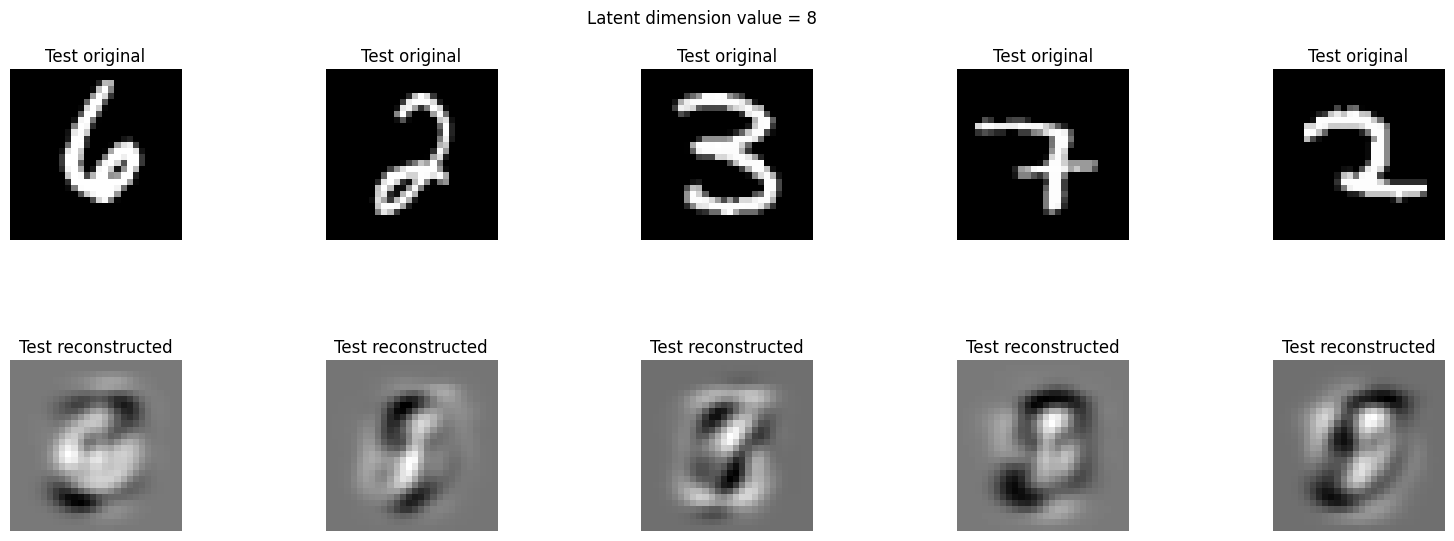

MSE val for latent dimension 16 is 0.07191685113844347


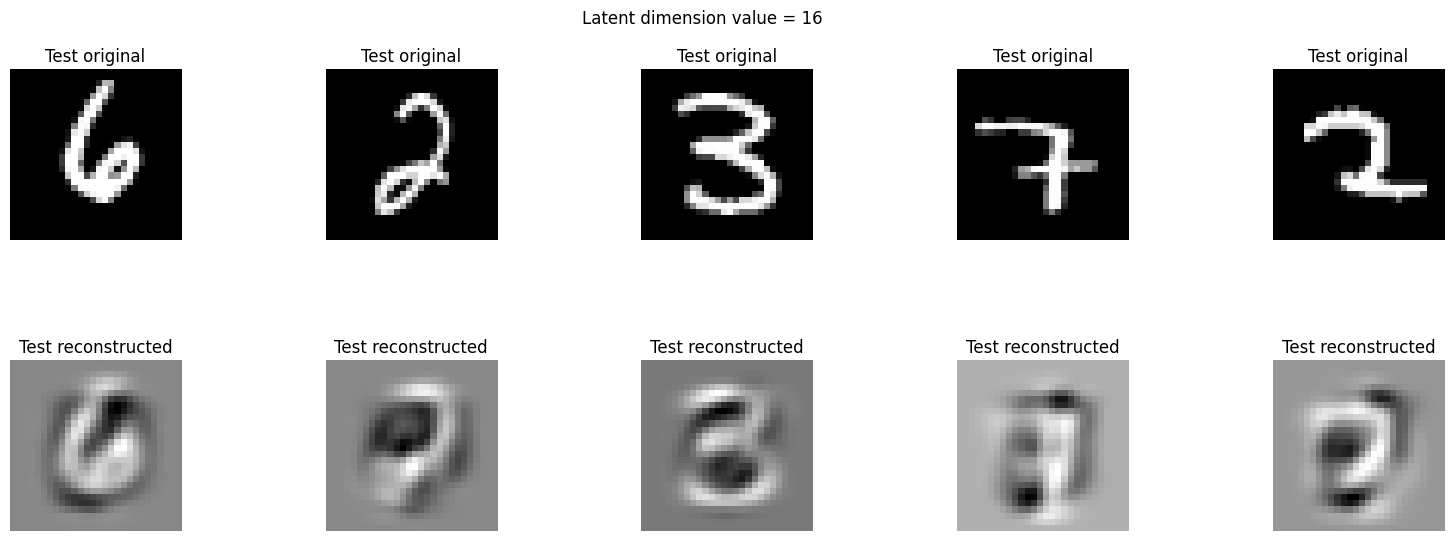

MSE val for latent dimension 32 is 0.06303978544636069


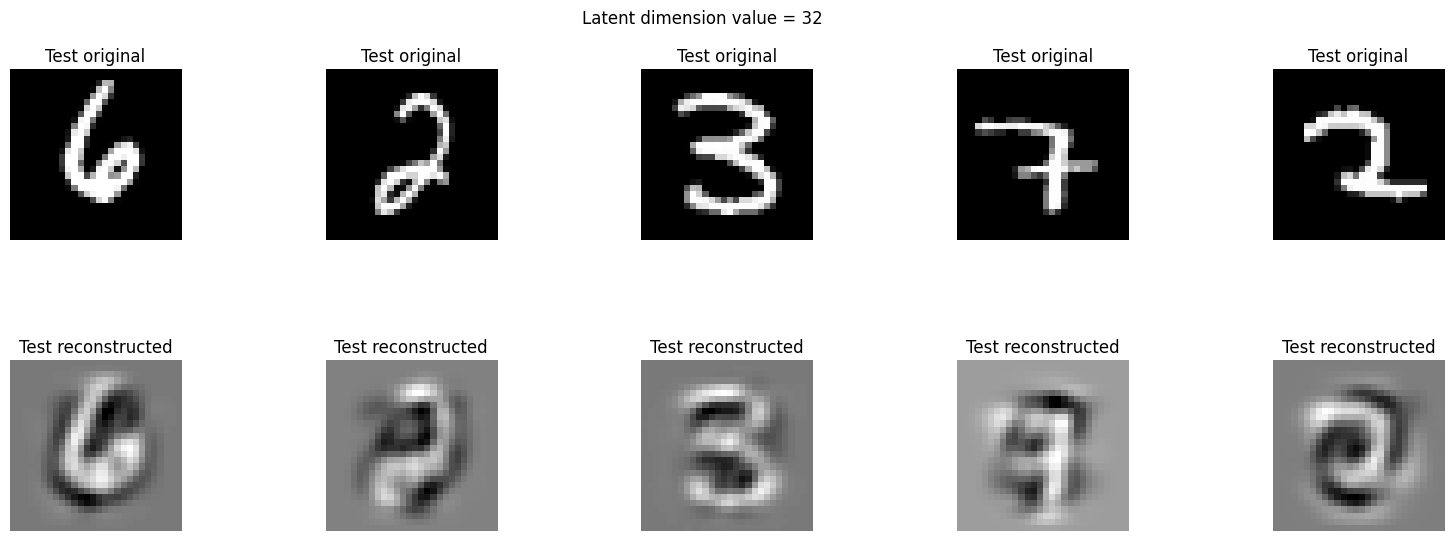

MSE val for latent dimension 64 is 0.05548393574838489


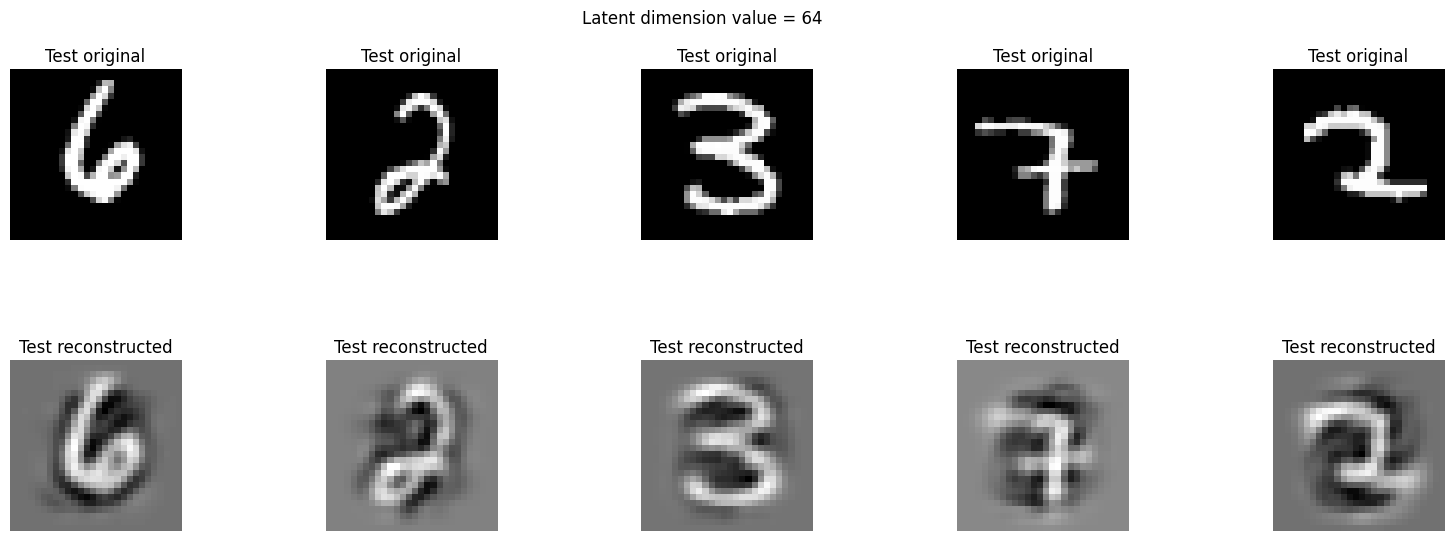

In [3]:
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64]

def probabilisticPCA(centeredTrainImages, latentDimensionValue):
    '''numSamples = normalizedTrainImages.shape[0]
    trainMean = np.mean(normalizedTrainImages, axis = 0)
    covarianceMatrix = np.zeros((normalizedTrainImages.shape[1], normalizedTrainImages.shape[1]))
    imgCount = 0
    for image in normalizedTrainImages:
        imgCount = imgCount + 1
        print(imgCount)

        image = image.reshape(-1,1)
        covarianceMatrix += np.dot(image - trainMean, (image - trainMean.T))

    covarianceMatrix = covarianceMatrix / numSamples'''
    covarianceMatrix = (centeredTrainImages.T @ centeredTrainImages) / len(centeredTrainImages)

    #nan_indices = np.where(np.isnan(covarianceMatrix))
    #print("Indices with NaN in Covariance Matrix:", nan_indices)


    #print("Any NaN in Covariance Matrix:", np.any(np.isnan(covarianceMatrix)))       
    
    eigenValues, eigenVectors = np.linalg.eigh(covarianceMatrix)


    Um = eigenVectors[:, -latentDimensionValue:]    
    Lm = np.diag(eigenValues[-latentDimensionValue:])   #Diagonal matrix of eigenvalues

    I = np.eye(latentDimensionValue)
    sigmaSquare = abs(np.mean(np.sum(eigenVectors) - np.sum(Um)))
    R = I  # Since its arbitrary, we take R as an identity matrix
    
    weights = Um @ np.sqrt(abs(Lm - sigmaSquare * I)) @ R

    return weights

def imageReconstruction(testImages, weights, mean, sigma, latentDimensionValue):

    #Z, residuals, _, _ = np.linalg.lstsq(weights.T @ weights + 1e-5 * np.eye(weights.shape[1]), weights.T @ (normalizedImages - mean).T, rcond=None) 
    #print("Weights.T @ Weights:", weights.T @ weights)
    #print("Weights.T @ (normalizedImages - mean).T:", weights.T @ (normalizedImages - mean).T)

    #Z = np.linalg.solve((weights.T @ weights), (weights.T) @ (normalizedImages - mean).T) 
    #X = WZ + u
    #return (weights @ Z).T + mean

    M = weights.T @ weights + sigma**2 * np.eye(latentDimensionValue)

    z = (np.linalg.inv(M) @ weights.T @ (testImages - mean).T)

    K = (weights @ (np.linalg.inv(weights.T @ weights)) @ M @ z).T
    x_pred = K + mean.reshape(-1,1).T
    return x_pred

trainMean = np.mean(flattenedTrainImages, axis = 0)
#standardDev = np.std(flattenedTrainImages, axis = 0)
#N = flattenedTrainImages.shape[0]
#D = flattenedTrainImages.shape[1]
sigma = 1.0
testMean = np.mean(flattenedTestImages, axis = 0)

centeredTrainImages = flattenedTrainImages - trainMean
centeredTestImages = (flattenedTestImages - testMean)

for latentDimensionValue in latentDimensions:

     
    weights = probabilisticPCA(centeredTrainImages, latentDimensionValue)
    reconstructedImages = imageReconstruction(centeredTestImages, weights, testMean, sigma, latentDimensionValue) 
    mseSum = 0

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent dimension value = {latentDimensionValue}")
    #print(reconstructedImages.shape)
    
    for idx in range(len(centeredTestImages)):
        #print(normalizedTestImages[idx])
        #print(reconstructedImage)
        mseVal = np.mean((flattenedTestImages[idx] - reconstructedImages[idx])**2)
        mseSum += mseVal
        
    finalMse = (mseSum) / len(centeredTestImages)
    print("MSE val for latent dimension {} is {}".format(latentDimensionValue,finalMse))

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(flattenedTestImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
    
    

## VARIATIONAL AUTOENCODER

Epoch 1/10
600/600 [==============================] - 6s 7ms/step - loss: 183.9312 - val_loss: 165.8284
Epoch 2/10
600/600 [==============================] - 4s 7ms/step - loss: 160.3175 - val_loss: 156.0358
Epoch 3/10
600/600 [==============================] - 6s 9ms/step - loss: 153.6283 - val_loss: 152.1029
Epoch 4/10
600/600 [==============================] - 7s 11ms/step - loss: 150.5179 - val_loss: 149.4665
Epoch 5/10
600/600 [==============================] - 6s 11ms/step - loss: 148.3288 - val_loss: 148.0008
Epoch 6/10
600/600 [==============================] - 5s 9ms/step - loss: 146.6324 - val_loss: 145.9314
Epoch 7/10
600/600 [==============================] - 6s 9ms/step - loss: 145.2919 - val_loss: 144.7913
Epoch 8/10
600/600 [==============================] - 8s 13ms/step - loss: 144.2680 - val_loss: 144.0881
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 143.4376 - val_loss: 143.2701
Epoch 10/10
313/313 [==============================] - 1s 2m

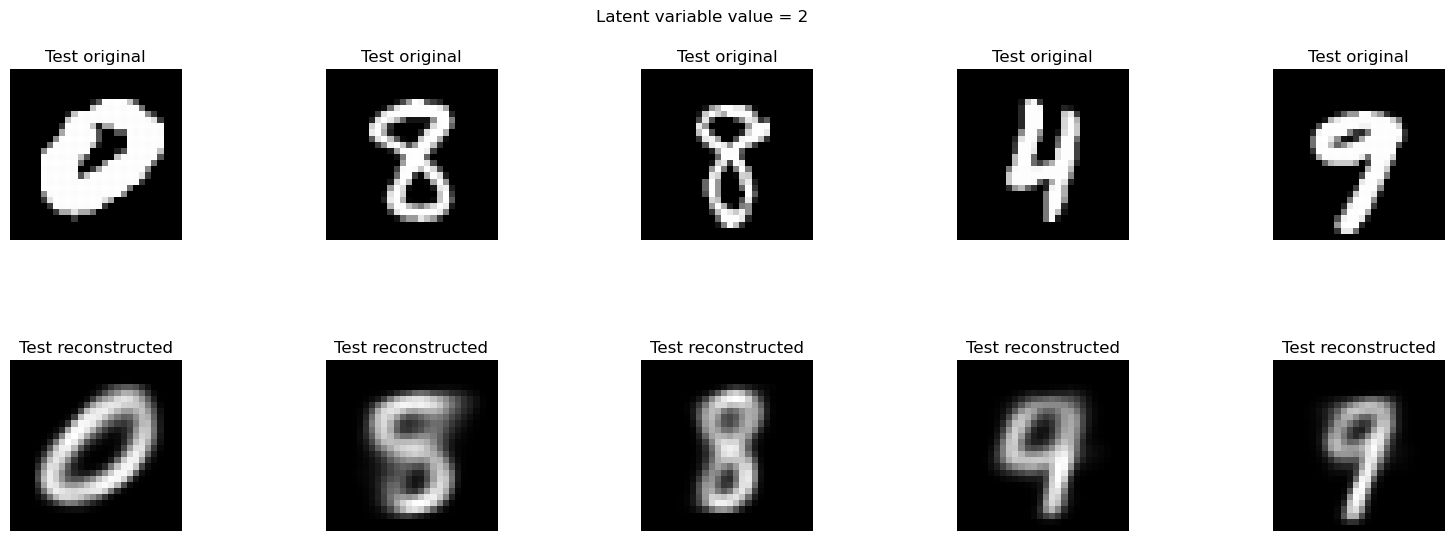

Epoch 1/10
600/600 [==============================] - 8s 11ms/step - loss: 174.8788 - val_loss: 145.8268
Epoch 2/10
600/600 [==============================] - 6s 10ms/step - loss: 139.8369 - val_loss: 134.9499
Epoch 3/10
600/600 [==============================] - 5s 9ms/step - loss: 133.0247 - val_loss: 130.0293
Epoch 4/10
600/600 [==============================] - 6s 9ms/step - loss: 129.4576 - val_loss: 128.2872
Epoch 5/10
600/600 [==============================] - 7s 12ms/step - loss: 127.0009 - val_loss: 125.7842
Epoch 6/10
600/600 [==============================] - 7s 11ms/step - loss: 125.1954 - val_loss: 124.6477
Epoch 7/10
600/600 [==============================] - 5s 9ms/step - loss: 123.8029 - val_loss: 123.1542
Epoch 8/10
600/600 [==============================] - 5s 9ms/step - loss: 122.6930 - val_loss: 122.8363
Epoch 9/10
600/600 [==============================] - 5s 9ms/step - loss: 121.7864 - val_loss: 121.6548
Epoch 10/10
313/313 [==============================] - 1s 2m

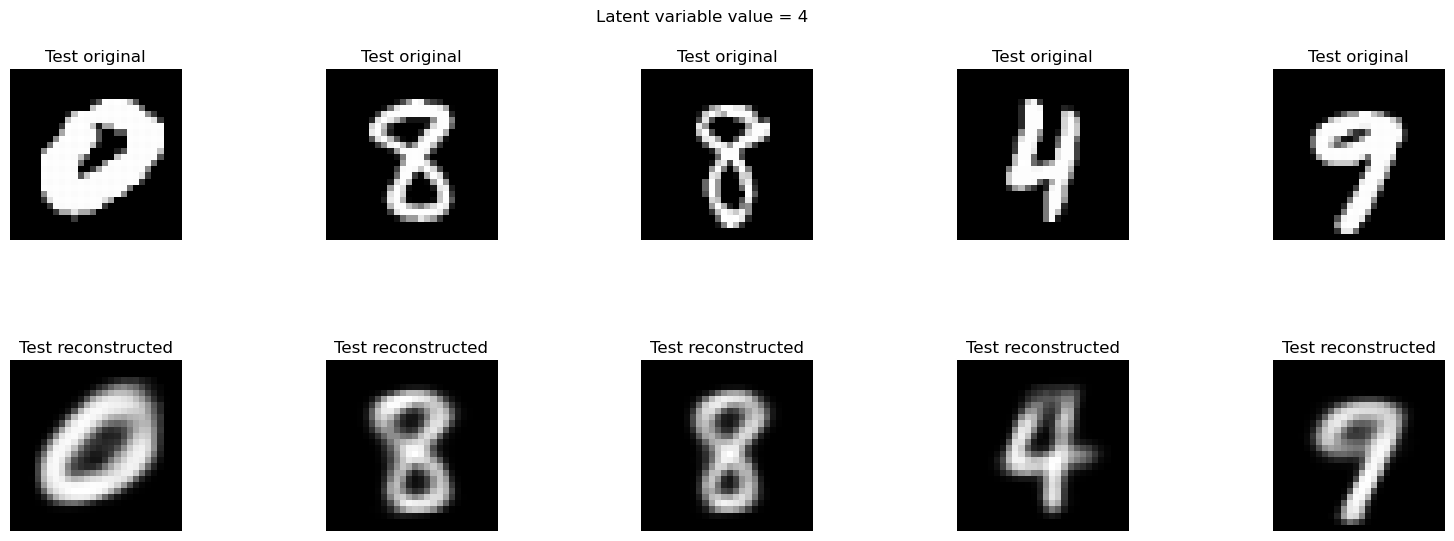

Epoch 1/10
600/600 [==============================] - 7s 9ms/step - loss: 167.5936 - val_loss: 129.3078
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 124.4111 - val_loss: 117.2687
Epoch 3/10
600/600 [==============================] - 6s 9ms/step - loss: 116.4282 - val_loss: 113.6954
Epoch 4/10
600/600 [==============================] - 6s 10ms/step - loss: 112.4357 - val_loss: 111.1427
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 109.7165 - val_loss: 107.6609
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 107.7538 - val_loss: 107.0819
Epoch 7/10
600/600 [==============================] - 6s 10ms/step - loss: 106.2673 - val_loss: 105.0238
Epoch 8/10
600/600 [==============================] - 5s 9ms/step - loss: 105.0844 - val_loss: 103.8933
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 104.1389 - val_loss: 104.6922
Epoch 10/10
313/313 [==============================] - 1s 2

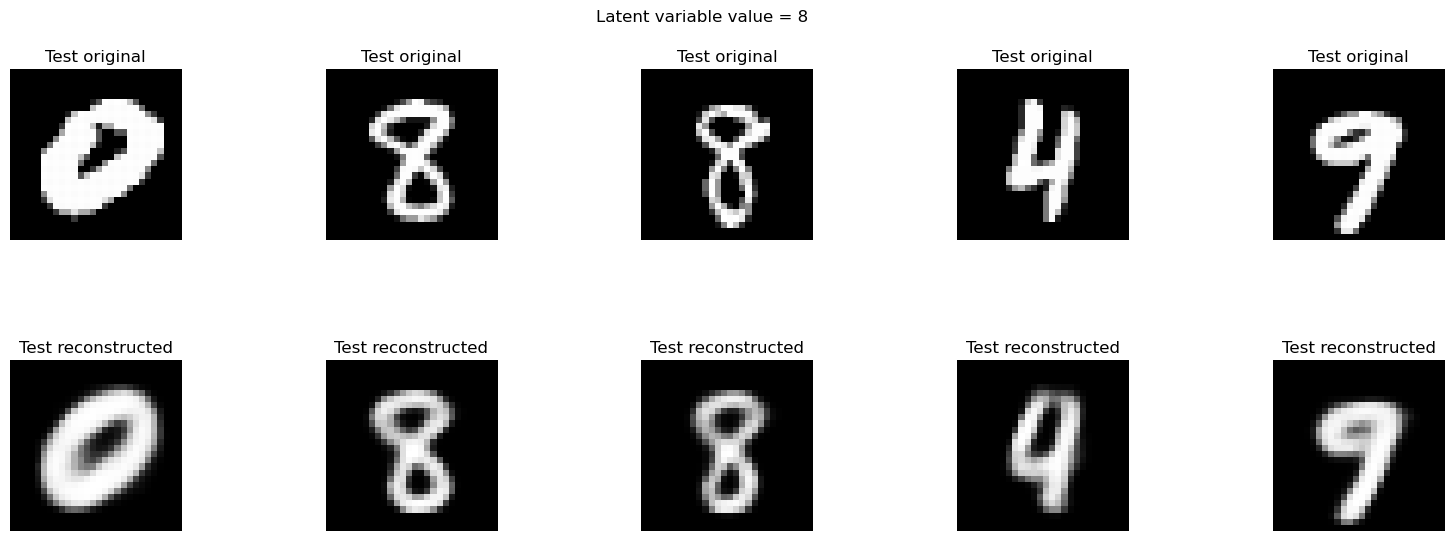

Epoch 1/10
600/600 [==============================] - 8s 11ms/step - loss: 162.6076 - val_loss: 131.2789
Epoch 2/10
600/600 [==============================] - 6s 10ms/step - loss: 123.7271 - val_loss: 117.3364
Epoch 3/10
600/600 [==============================] - 5s 9ms/step - loss: 112.5242 - val_loss: 108.0462
Epoch 4/10
600/600 [==============================] - 6s 10ms/step - loss: 107.2855 - val_loss: 103.9434
Epoch 5/10
600/600 [==============================] - 5s 9ms/step - loss: 103.8823 - val_loss: 102.4575
Epoch 6/10
600/600 [==============================] - 5s 9ms/step - loss: 101.5214 - val_loss: 99.8041
Epoch 7/10
600/600 [==============================] - 5s 9ms/step - loss: 99.8066 - val_loss: 98.3435
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 98.5859 - val_loss: 96.5926
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 97.5705 - val_loss: 96.3705
Epoch 10/10
313/313 [==============================] - 1s 2ms/step

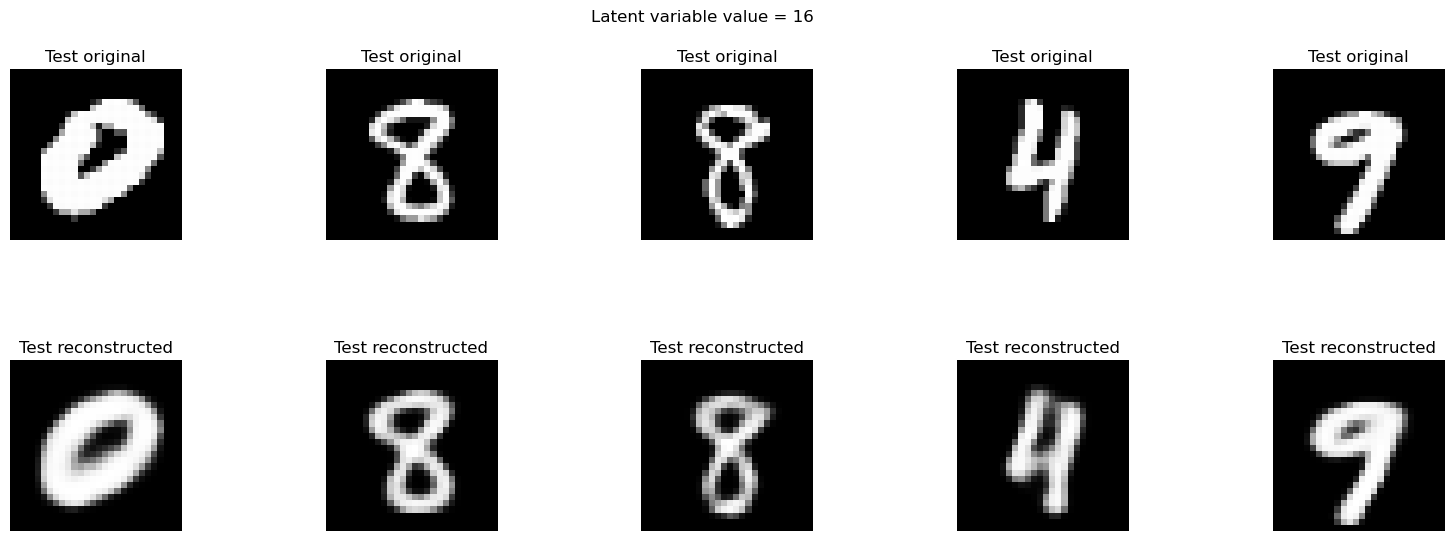

Epoch 1/10
600/600 [==============================] - 6s 9ms/step - loss: 165.3471 - val_loss: 135.1931
Epoch 2/10
600/600 [==============================] - 5s 9ms/step - loss: 127.0080 - val_loss: 117.1817
Epoch 3/10
600/600 [==============================] - 5s 9ms/step - loss: 114.6397 - val_loss: 108.2141
Epoch 4/10
600/600 [==============================] - 6s 10ms/step - loss: 108.1138 - val_loss: 105.9904
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 104.1143 - val_loss: 101.4533
Epoch 6/10
600/600 [==============================] - 6s 11ms/step - loss: 101.6073 - val_loss: 99.2350
Epoch 7/10
600/600 [==============================] - 6s 10ms/step - loss: 99.8209 - val_loss: 99.5657
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 98.4608 - val_loss: 98.0938
Epoch 9/10
600/600 [==============================] - 6s 9ms/step - loss: 97.4202 - val_loss: 96.1219
Epoch 10/10
313/313 [==============================] - 1s 2ms/step

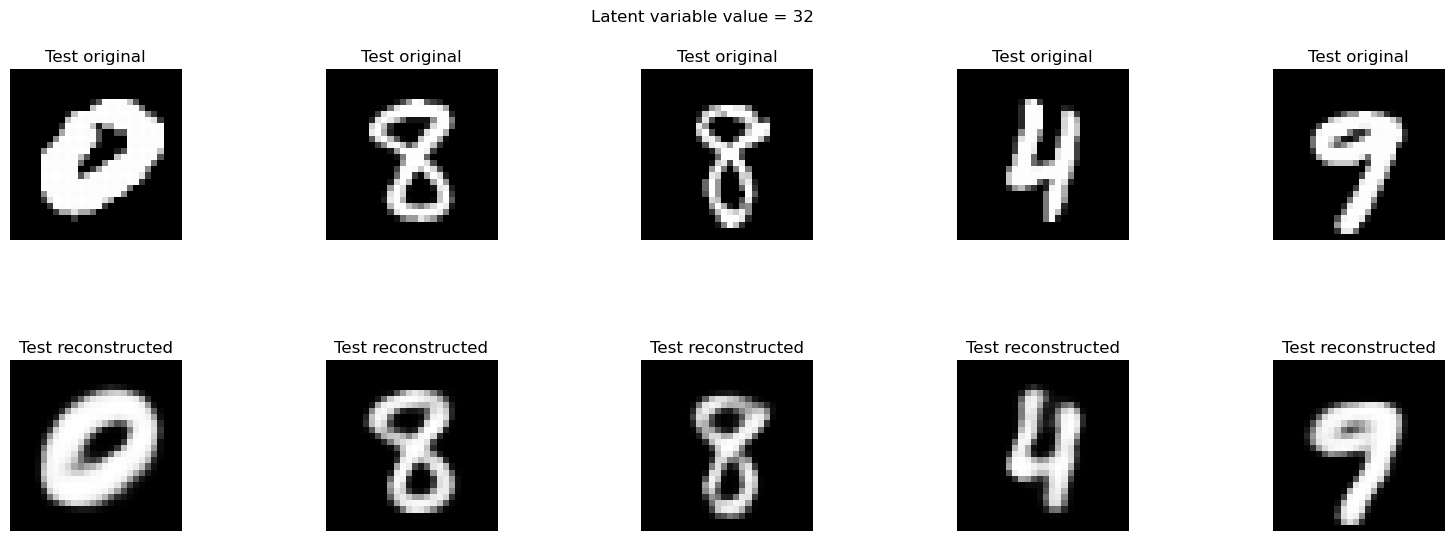

Epoch 1/10
600/600 [==============================] - 8s 11ms/step - loss: 167.2147 - val_loss: 138.9102
Epoch 2/10
600/600 [==============================] - 6s 9ms/step - loss: 130.3768 - val_loss: 122.4285
Epoch 3/10
600/600 [==============================] - 6s 10ms/step - loss: 117.8605 - val_loss: 114.5463
Epoch 4/10
600/600 [==============================] - 6s 9ms/step - loss: 110.4599 - val_loss: 106.2148
Epoch 5/10
600/600 [==============================] - 6s 9ms/step - loss: 105.6152 - val_loss: 103.9642
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 102.4754 - val_loss: 100.5276
Epoch 7/10
600/600 [==============================] - 6s 9ms/step - loss: 100.1812 - val_loss: 99.4918
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 98.5824 - val_loss: 98.0316
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 97.3897 - val_loss: 95.4950
Epoch 10/10
313/313 [==============================] - 1s 2ms/st

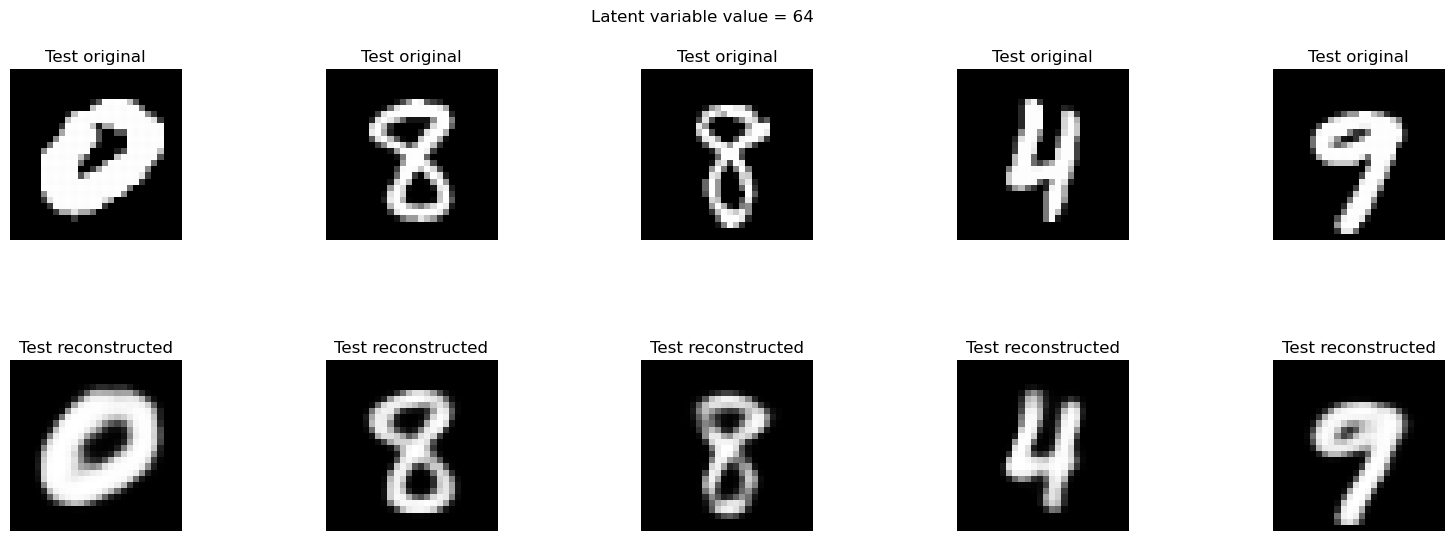

In [5]:
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from scipy.stats import norm

latentDimensions = [2, 4, 8, 16, 32, 64]
# latentDimensions = [2]
randomImages = random.sample(range(len(testImages)), 5)

batch_size, epoch = 100, 10
n_hidden = 256

def normalization(flattenedTrainImages):
    mean = np.mean(flattenedTrainImages, axis = 0)
    standardDev = np.std(flattenedTrainImages, axis = 0)

    #Handle 0 variance here, else NaN values are produced
    zeroVarianceIndices = np.where(standardDev == 0)[0]
    standardDev[zeroVarianceIndices] = 1e-5

    normalizedImages = (flattenedTrainImages - mean) / standardDev
    return normalizedImages, mean, standardDev

def variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue):
    
    x = Input(shape=(flattenedTrainImages.shape[1:]))
    h1 = Dense(256, activation='relu')(x)
    h1 = Dense(128, activation='relu')(h1)

    mu = Dense(latentDimensionValue)(h1)
    log_var = Dense(latentDimensionValue)(h1)

    def sampling(args):
        mu, log_var = args
        eps = K.random_normal(shape=(batch_size, latentDimensionValue), mean=0., stddev=1.0)
        return mu + K.exp(log_var) * eps

    z = Lambda(sampling, output_shape=(latentDimensionValue,))([mu, log_var])

    z1 = Dense(128, activation='relu')
    z2 = Dense(256, activation='relu')
    y_decoder = Dense(flattenedTrainImages.shape[1], activation='sigmoid')

    h2 = z1(z)
    h2 = z2(h2)
    y = y_decoder(h2)

    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    reconstruction_loss = K.sum(K.binary_crossentropy(x, y), axis=-1)

    vae_loss = reconstruction_loss + kl_loss

    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    vae.fit(flattenedTrainImages,epochs=epoch,batch_size=batch_size,validation_data=(flattenedTestImages, None), verbose=1)

    encoder = Model(x, mu)
    z_latent = encoder.predict(flattenedTestImages, batch_size=batch_size)

    decoder_input = Input(shape=(latentDimensionValue,))
    h3 = z1(decoder_input)
    h3 = z2(h3)
    generatedImage = y_decoder(h3)
    generator = Model(decoder_input, generatedImage)

    reconstructed = generator.predict(z_latent)
    
    return reconstructed


normalizedTrainImages, mean, standardDev = normalization(flattenedTrainImages)

for latentDimensionValue in latentDimensions:

    normalizedTestImages = (flattenedTestImages - mean) / standardDev
    reconstructedImages = variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue)
    mseVal = np.mean(np.square(flattenedTestImages - reconstructedImages))

    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent variable value = {latentDimensionValue}")

    for i, idx in enumerate(randomImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        # reconstructed_image_np = reconstructedImages[idx].numpy()
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()